In [ ]:
# Working on this file while taking ideas/code from original repo.

In [68]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

import scipy.stats as st

In [69]:
# working directory
wd = '/home/seherkhan/myfiles/git/rossman_TSA_forecasts/'

# importing train data to learn
train = pd.read_csv(wd + "train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv(wd + "store.csv", 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [70]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


Short description:
- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

**Notes for Target Project:**
- Will require product wise sales
- Plan on cummulating daily sales into weekly sales

In [71]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Short Description:  
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo: indicates whether a store is running a promo on that day [*This is in the train table*]
- Promo2: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [72]:
# Missing values
print(train.isnull().sum())
print()
print(store.isnull().sum())

# how to handle these?

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [73]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
print(train['SalePerCustomer'].describe())
print()
print(train['SalePerCustomer'].isna().sum())

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

172869


On average customers spend about $9.50 per day. Though there are days with Sales equal to zero.  
Sales per customer is skewed to the right.  

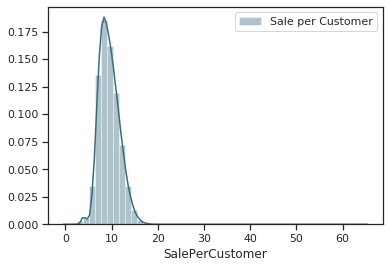

In [74]:
sns.distplot(train["SalePerCustomer"][train["Open"]==1].dropna(), label="Sale per Customer",color="#386B7F")
plt.legend()
plt.show()

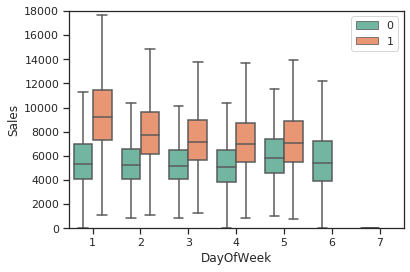

In [75]:
tmp_plot = sns.boxplot(x="DayOfWeek", y="Sales", hue="Promo", palette="Set2", data=train,fliersize=0)
tmp_plot.set_ylim(0,18000)
tmp_plot.legend(loc="upper right")

1115
1105

Frequency of Stores that were open on given number of Sundays


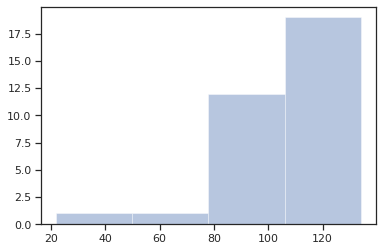

In [136]:
print(len(np.unique(store['Store'])))
print(len(np.unique(train['Store'][(train['DayOfWeek']==7)&(train['Open']==0)])))
print()
tmp_tab = train[['Store','Open']][(train['DayOfWeek']==7)&(train['Open']==1)].groupby('Store').count().sort_values('Open')
print('Frequency of Stores that were open on given number of Sundays')
sns.distplot(tmp_tab,kde=False,norm_hist=False, bins=None)

There are 1115 stores.  
Sales per day from Monday to Thursday don't show a lot of variation. Sales are higher on Fridays and Saturdays.  
Greatest variability in Sales occurs on Saturdays.  
Promo seems to impact sales per day strongly. They seem to work well specially on Mondays.  
33 stores have remained open on Sunday at least once.

### ECDF: empirical cumulative distribution function  
To get the first impression about continious variables in the data we can plot ECDF.

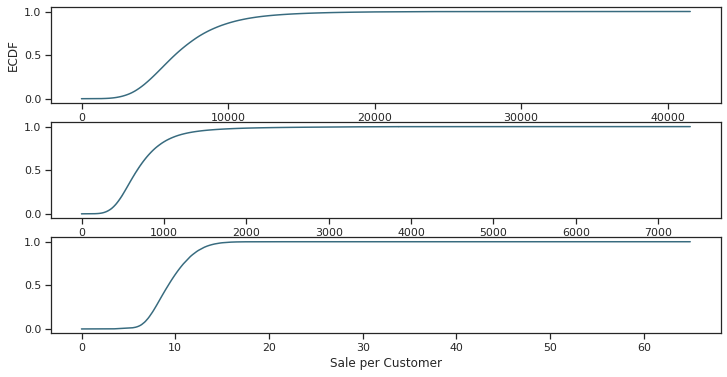

In [76]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'][train["Open"]==1])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'][train["Open"]==1])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'][train["Open"]==1])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

Around 90% of the days, sales were less than \\$10000   
Around 90% of the days, customers visting a shop were less than \\$1000   
Around 90% of the days, sales were customer were less than \\$12  

In [77]:
print(len(train[(train.Open == 1) & (train.Sales ==0)]))
print(len(train[(train.Open == 0) & (train.Sales!=0)]))
print(len(train[train.Open == 0]))

54
0
172817


There are 54 days on which a store was open and had no sales  
There are no days on which a store was closed but sales took place (mistyping/etc)
There are 172817 days on which a store was marked closed. I decided not to drop these since my model should be able to handle such instances.

In [78]:
test = pd.read_csv(wd + "test.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
print('train keys: ', list(train.keys()))
print('test keys: ', list(test.keys()))

train keys:  ['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear', 'SalePerCustomer']
test keys:  ['Id', 'Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
